Fetching data for SPY...
--- Results for SPY ---
Total Market Return:   55.81%
Total Strategy Return: 51.63%
Strategy Sharpe Ratio: 1.01


/tmp/ipython-input-2646188654.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", end="2024-01-01", progress=False)


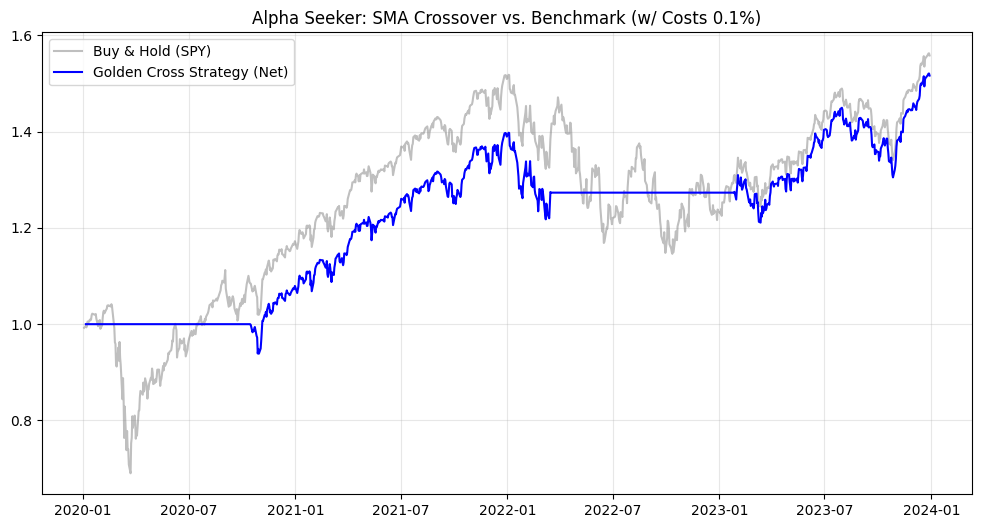

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. DATA PIPELINE
# Fetching real data, not random numbers.
# ==========================================
ticker = "SPY"
print(f"Fetching data for {ticker}...")
data = yf.download(ticker, start="2020-01-01", end="2024-01-01", progress=False)

# Clean up: We only need the 'Close' price for this simple strategy
df = data[['Close']].copy()
df.rename(columns={'Close': 'price'}, inplace=True)

# ==========================================
# 2. THE STRATEGY (Golden Cross)
# Logic: Buy when Short MA > Long MA
# ==========================================
short_window = 50
long_window = 200

# Calculate Moving Averages
df['short_ma'] = df['price'].rolling(window=short_window).mean()
df['long_ma'] = df['price'].rolling(window=long_window).mean()

# Generate Signal (1 = Buy/Hold, 0 = Cash/Sell)
# Shift(1) is CRITICAL: We must trade based on *yesterday's* close to avoid look-ahead bias
df['signal'] = 0.0
df['signal'] = np.where(df['short_ma'] > df['long_ma'], 1.0, 0.0)
df['position'] = df['signal'].shift(1)

# ==========================================
# 3. THE "GUARDS" (Transaction Costs)
# ==========================================
# We check when the position *changed* to apply a fee
cost_per_trade = 0.0010  # 0.10% per trade (slippage + comms)
df['trade_occurred'] = df['position'].diff().abs()

# Calculate Daily Returns
df['market_return'] = df['price'].pct_change()
df['strategy_raw'] = df['market_return'] * df['position']

# Apply costs only on days we traded
df['strategy_net'] = df['strategy_raw'] - (df['trade_occurred'] * cost_per_trade)

# ==========================================
# 4. PERFORMANCE ANALYTICS
# Proving it works with math.
# ==========================================
# Cumulative Returns (Compounded)
df['cum_market'] = (1 + df['market_return']).cumprod()
df['cum_strategy'] = (1 + df['strategy_net']).cumprod()

# Calculate Sharpe Ratio (assuming 0% risk-free rate for simplicity)
# Annualized by multiplying by sqrt(252 trading days)
daily_mean = df['strategy_net'].mean()
daily_std = df['strategy_net'].std()
sharpe_ratio = (daily_mean / daily_std) * (252**0.5)

print(f"--- Results for {ticker} ---")
print(f"Total Market Return:   {(df['cum_market'].iloc[-1] - 1)*100:.2f}%")
print(f"Total Strategy Return: {(df['cum_strategy'].iloc[-1] - 1)*100:.2f}%")
print(f"Strategy Sharpe Ratio: {sharpe_ratio:.2f}")

# ==========================================
# 5. VISUALIZATION
# ==========================================
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['cum_market'], label='Buy & Hold (SPY)', color='grey', alpha=0.5)
plt.plot(df.index, df['cum_strategy'], label='Golden Cross Strategy (Net)', color='blue')
plt.title(f"Alpha Seeker: SMA Crossover vs. Benchmark (w/ Costs {cost_per_trade*100}%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

--- Fetching data for SPY ---
Testing 135 combinations...
Running simulation (this may take 10-20 seconds)...


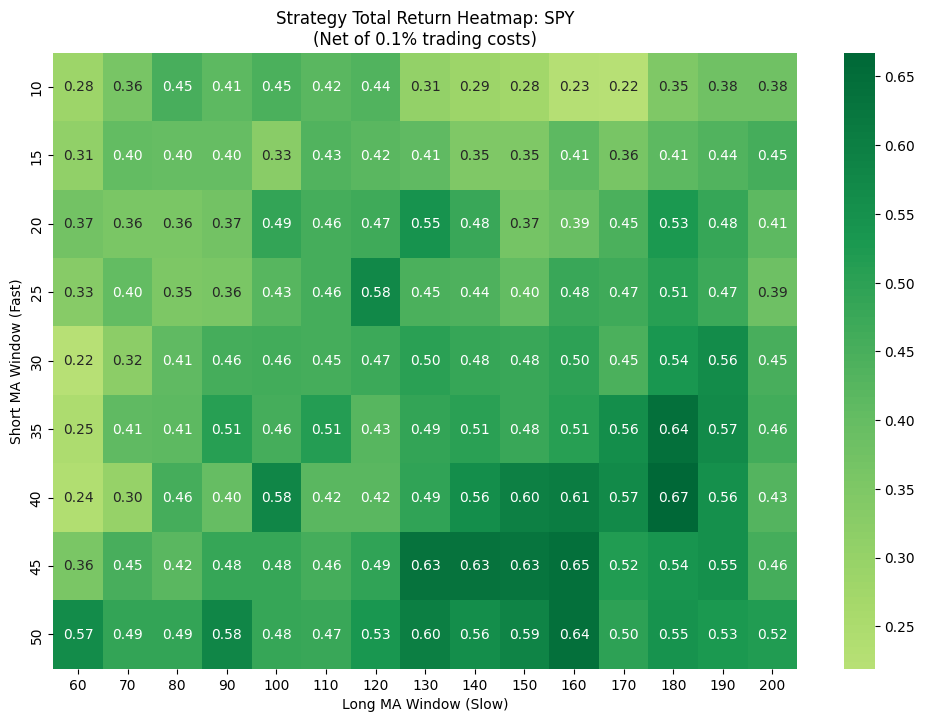

--- BEST COMBINATION ---
Short Window: 40
Long Window:  180
Total Return: 66.73%


In [7]:
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# ==========================================
# 1. DATA PIPELINE (ROBUST VERSION)
# ==========================================
ticker = "SPY"
print(f"--- Fetching data for {ticker} ---")
data = yf.download(ticker, start="2020-01-01", end="2024-01-01", progress=False)

# FIX: Handle yfinance MultiIndex formatting (The common error source)
if isinstance(data.columns, pd.MultiIndex):
    # If data comes as ('Price', 'Ticker'), drop the ticker level
    data.columns = data.columns.get_level_values(0)

# Ensure we have a clean DataFrame with just the Close price
df = data[['Close']].copy()
df.rename(columns={'Close': 'price'}, inplace=True)

# ==========================================
# 2. DEFINE THE OPTIMIZATION GRID
# ==========================================
# We test Short MAs (10 to 50) vs Long MAs (60 to 200)
short_windows = range(10, 55, 5)  # 10, 15, 20...
long_windows = range(60, 210, 10) # 60, 70, 80...

print(f"Testing {len(short_windows) * len(long_windows)} combinations...")
print("Running simulation (this may take 10-20 seconds)...")

results = []
cost_per_trade = 0.0010  # 0.10% per trade

# ==========================================
# 3. THE OPTIMIZATION LOOP
# ==========================================
for short in short_windows:
    for long in long_windows:
        if short >= long:
            continue # Skip invalid combinations (Short must be < Long)

        # Create a temp copy for this specific iteration
        temp_df = df.copy()

        # Calculate Moving Averages
        temp_df['short_ma'] = temp_df['price'].rolling(window=short).mean()
        temp_df['long_ma'] = temp_df['price'].rolling(window=long).mean()

        # Generate Signal
        # 1 = Buy, 0 = Sell/Cash
        temp_df['signal'] = np.where(temp_df['short_ma'] > temp_df['long_ma'], 1.0, 0.0)

        # Shift(1) prevents look-ahead bias
        temp_df['position'] = temp_df['signal'].shift(1)

        # Calculate Trade Costs
        # We detect a trade when the position changes (0 to 1 or 1 to 0)
        temp_df['trade_occurred'] = temp_df['position'].diff().abs()

        # Calculate Net Returns
        # Market Return * Position - Costs
        market_return = temp_df['price'].pct_change()
        temp_df['strategy_net'] = (market_return * temp_df['position']) - (temp_df['trade_occurred'] * cost_per_trade)

        # Calculate Cumulative Total Return for this combination
        # We use 'fillna(0)' to handle the start of the data where MAs are calculating
        cum_return = (1 + temp_df['strategy_net'].fillna(0)).cumprod().iloc[-1] - 1

        results.append({
            'Short_Window': short,
            'Long_Window': long,
            'Return': cum_return
        })

# ==========================================
# 4. VISUALIZATION (HEATMAP)
# ==========================================
results_df = pd.DataFrame(results)

# Pivot data: Rows=Short, Cols=Long, Values=Return
heatmap_data = results_df.pivot(index='Short_Window', columns='Long_Window', values='Return')

plt.figure(figsize=(12, 8))
# cmap="RdYlGn" makes positive green, negative red
# center=0 ensures 0% return is the neutral color (yellow/white)
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="RdYlGn", center=0)

plt.title(f"Strategy Total Return Heatmap: {ticker}\n(Net of {cost_per_trade*100}% trading costs)")
plt.ylabel("Short MA Window (Fast)")
plt.xlabel("Long MA Window (Slow)")
plt.show()

# Find the absolute best combination
best_run = results_df.loc[results_df['Return'].idxmax()]
print(f"--- BEST COMBINATION ---")
print(f"Short Window: {int(best_run['Short_Window'])}")
print(f"Long Window:  {int(best_run['Long_Window'])}")
print(f"Total Return: {best_run['Return']*100:.2f}%")

Fetching data for SPY...
Starting Walk-Forward Analysis...
Year 2020: Optimized on 2018-2019. Best Params found: 10/120
Year 2021: Optimized on 2019-2020. Best Params found: 10/100
Year 2022: Optimized on 2020-2021. Best Params found: 40/100
Year 2023: Optimized on 2021-2022. Best Params found: 50/120
--- FINAL RESULTS ---
Walk-Forward Return: 20.67%
Buy & Hold Return:   57.27%


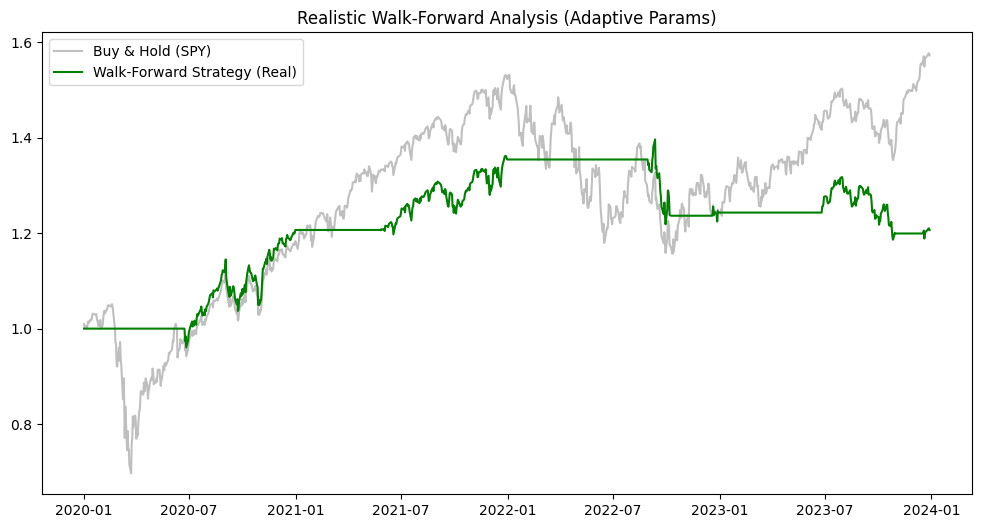

In [8]:
# ==========================================
# 1. PREPARE DATA
# ==========================================
# We need a longer timeframe to allow for a "training" period
ticker = "SPY"
print(f"Fetching data for {ticker}...")
data = yf.download(ticker, start="2018-01-01", end="2024-01-01", progress=False)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

df = data[['Close']].copy()
df.rename(columns={'Close': 'price'}, inplace=True)
df['pct_change'] = df['price'].pct_change()

# ==========================================
# 2. HELPER FUNCTION: THE OPTIMIZER
# Finds best params for a specific chunk of data
# ==========================================
def find_best_params(sub_df):
    best_return = -999
    best_pair = (50, 200) # Default fallback

    # Smaller grid for speed in this demo
    shorts = range(10, 55, 10)
    longs = range(60, 210, 20)

    for s in shorts:
        for l in longs:
            if s >= l: continue

            # Vectorized backtest on this chunk
            sma_s = sub_df['price'].rolling(s).mean()
            sma_l = sub_df['price'].rolling(l).mean()
            sig = np.where(sma_s > sma_l, 1.0, 0.0)
            pos = pd.Series(sig, index=sub_df.index).shift(1)

            # Simple return calc (ignoring costs for speed of optimization loop)
            ret = (sub_df['pct_change'] * pos).sum()

            if ret > best_return:
                best_return = ret
                best_pair = (s, l)

    return best_pair

# ==========================================
# 3. THE WALK-FORWARD LOOP
# ==========================================
print("Starting Walk-Forward Analysis...")

# We will re-optimize at the start of each year
years = df.index.year.unique()
start_year = 2020 # Start trading in 2020 (using 2018-2019 as first training data)

# Store our "Real" trading results here
walk_forward_results = []

for current_year in range(start_year, 2024):
    # A. DEFINE TRAINING PERIOD (Previous 2 years)
    train_start = str(current_year - 2)
    train_end = str(current_year - 1)
    train_data = df.loc[train_start : train_end]

    # B. FIND BEST PARAMS based on training data
    best_s, best_l = find_best_params(train_data)
    print(f"Year {current_year}: Optimized on {train_start}-{train_end}. Best Params found: {best_s}/{best_l}")

    # C. TRADE THE "UNKNOWN" FUTURE (Current Year)
    test_data = df.loc[str(current_year)].copy()

    # Apply the params we just found to this new data
    test_data['short_ma'] = test_data['price'].rolling(best_s).mean()
    test_data['long_ma'] = test_data['price'].rolling(best_l).mean()
    test_data['signal'] = np.where(test_data['short_ma'] > test_data['long_ma'], 1.0, 0.0)
    test_data['position'] = test_data['signal'].shift(1)

    # Calculate Returns (With Costs this time)
    cost = 0.0010
    trade_occurred = test_data['position'].diff().abs()
    test_data['strategy_net'] = (test_data['pct_change'] * test_data['position']) - (trade_occurred * cost)

    walk_forward_results.append(test_data[['strategy_net']])

# ==========================================
# 4. COMBINE & VISUALIZE
# ==========================================
full_strategy = pd.concat(walk_forward_results)
full_strategy['cum_return'] = (1 + full_strategy['strategy_net'].fillna(0)).cumprod()

# Get Benchmark for same period
benchmark = df.loc[full_strategy.index].copy()
benchmark['cum_return'] = (1 + benchmark['pct_change']).cumprod()

print(f"--- FINAL RESULTS ---")
print(f"Walk-Forward Return: {(full_strategy['cum_return'].iloc[-1] - 1)*100:.2f}%")
print(f"Buy & Hold Return:   {(benchmark['cum_return'].iloc[-1] - 1)*100:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(benchmark.index, benchmark['cum_return'], label='Buy & Hold (SPY)', color='grey', alpha=0.5)
plt.plot(full_strategy.index, full_strategy['cum_return'], label='Walk-Forward Strategy (Real)', color='green')
plt.title("Realistic Walk-Forward Analysis (Adaptive Params)")
plt.legend()
plt.show()